<a href="https://colab.research.google.com/github/GuilhermeLoboSousa/sistemasinteligentes/blob/main/group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Synergy Prediction

1.   Exploração inical e pré-processamento
2.   Análise não supervisionada




## Group 1
Guilherme Sousa

Joana Araújo

Karyna Lysenko

Tiago Silva

**Exploração inical e pré-processamento**

**Definition**: Synergy is a dimensionless measure of deviation of an observed drug combination response from the expected effect of non-interaction. Synergy can be calculated using different models such as the Bliss model, Highest Single Agent (HSA), Loewe additivity model and Zero Interaction Potency (ZIP). Another relevant metric is CSS which measures the drug combination sensitivity and is derived using relative IC50 values of compounds and the area under their dose-response curves.

**Impact**: Drug combination therapy offers enormous potential for expanding the use of existing drugs and in improving their efficacy. For instance, the simultaneous modulation of multiple targets can address the common mechanisms of drug resistance in the treatment of cancers. However, experimentally exploring the entire space of possible drug combinations is not a feasible task. Computational models that can predict the therapeutic potential of drug combinations can thus be immensely valuable in guiding this exploration.

**Generalization**: It is important for model predictions to be able to adapt to varying underlying biology as captured through different cell lines drawn from multiple tissues of origin. Dosage is also an important factor that can impact model generalizability.

**Product**: Small-molecule.

**Pipeline**: Activity.

Link:https://tdcommons.ai/multi_pred_tasks/drugsyn/

**Dataset Description**: A large-scale oncology screen produced by Merck & Co., where each sample consists of two compounds and a cell line. The dataset covers 583 distinct combinations, each tested against 39 human cancer cell lines derived from 7 different tissue types. Pairwise combinations were constructed from 38 diverse anticancer drugs (14 experimental and 24 approved). The synergy score is calculated by Loewe Additivity values using the batch processing mode of Combenefit. The genomic features are from ArrayExpress database (accession number: E-MTAB-3610) and was quantile normalized and summarized with Factor Analysis for Robust Microarray Summarization (FARMS). The processed data is provided by DeepSynergy.

**Task Description**: Regression. Given the gene expression of cell lines and two SMILES strings of the drug combos, predict the drug synergy level.

**Dataset Statistics**: 23,052 drug combo-cell line points, among 39 cancer cell lines and 37 drugs

# Imports

In [1]:
from tdc.multi_pred import DrugSyn
import pandas as pd

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger

import numpy as np
from rdkit.Chem.GraphDescriptors import Ipc
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

from collections import OrderedDict

from rdkit.Chem import AllChem

from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole


# Etapa 1

Nesta fase o nosso objetivo foi construir e filtrar o nosso dataset. Para isso, é necessário ter em atenção que a drug1 e drug2, inicialmente, não estavam standerdizadas, a info das cell line estava dentro de listas e, que necessitariamos de features como descritores e morgan.

Depois realizamos uma filtragem ao nosso dataset, diminuindo o  número de features (critério de variancia) e o número de linhas (removendo outliers).

Guardamos o dataset resultatante num ficheiro csv com o nome dataset.csv

**Carregar o dataset**

In [2]:
data = DrugSyn(name = "OncoPolyPharmacology")
dataset=data.get_data()
dataset

Downloading...
100%|██████████| 1.62G/1.62G [25:48<00:00, 1.05MiB/s]  
Loading...
Done!


,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...


Standerization da estrutura química de cada droga



In [3]:
drogas_unicas = list(OrderedDict.fromkeys(dataset['Drug1'])) #drug 1 ou drug 2 têm as mesmas drogas mas em ordem diferente
print(drogas_unicas)


['O=c1[nH]cc(F)c(=O)[nH]1', 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1', 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1', 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21', 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', 'N.N.O=C(O)C1(C(=O)O)CCC1.[Pt]', 'O=P1(N(CCCl)CCCl)NCCCO1', 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1', 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O', 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1', 'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 'CN(C)C(=N)N=C(N)N', 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1'

In [4]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria
RDLogger.DisableLog('rdApp.*') # disable rdkit warnings

def standardize(smiles):
    # convert to mol object
    mol = Chem.MolFromSmiles(smiles)

    # avoid errors with invalid molecules
    if mol is None:
        return None

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # convert back to smiles
    uncharged_parent_clean_smiles = Chem.MolToSmiles(uncharged_parent_clean_mol)
    return uncharged_parent_clean_smiles

# apply the function to the SMILES column
resultados_stander=[]
for droga in drogas_unicas:
  resultado=standardize(droga)
  resultados_stander.append(resultado)
print(resultados_stander)
#standardized_data = dataset.copy().apply(lambda x: standardize(x['Drug1']), axis=1)
#standardized_data.head()

['O=c1[nH]cc(F)c(=O)[nH]1', 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1', 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1', 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21', 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O', 'O=C(O)C1(C(=O)O)CCC1', 'O=P1(N(CCCl)CCCl)NCCCO1', 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1', 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO', 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O', 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O', 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1', 'N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1', 'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 'CN(C)C(=N)N=C(N)N', 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1', 'COC12C

Após ter a droga standerdizada, procedemos ao cálculo dos descritores e morgan fingerprints, para enriquecer o nosso dataset

In [5]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria

# 2D descriptors
def get_descriptors(smiles):
    feature_names = [x[0] for x in Descriptors._descList]
    try:
        mol = Chem.MolFromSmiles(smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_names)
        # Deal with very large/inf values of the Ipc descriptor (https://github.com/rdkit/rdkit/issues/1527)
        # find position of Ipc
        pos = feature_names.index("Ipc")
        # calculate AvgIpc
        avg_ipc = Ipc(mol, avg=1)

        descriptors = list(calc.CalcDescriptors(mol))
        # replace Ipc with AvgIpc
        descriptors[pos] = avg_ipc
        descriptors = np.array(descriptors, dtype=np.float32)
        return descriptors
    except:
        # return np array of nans of size feature_names
        return np.empty(len(feature_names)) * np.nan


In [6]:
#Nota que esta função foi nos dada na aula , e por isso, não é da nossa autoria

# Morgan fingerprints

def get_morgan_fingerprints(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        morgan_fingerprints = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(morgan_fingerprints, np.float32)
    except:
        # return np array of nans of size feature_names
        return np.empty(1024) * np.nan

Optamos por juntar num dicionario as drogas standerdizadas, os descritores e as morgan para numa fase posterior conseguir acrescentar ao nosso dataset

In [7]:
dic={}
for droga in drogas_unicas:
  droga_padronizada=standardize(droga)
  descritores=get_descriptors(droga_padronizada)
  descritores=descritores.reshape(-1,1)
  scaler = StandardScaler()
  descritores_normalizados = scaler.fit_transform(descritores)
  descritores_final=descritores_normalizados.flatten()
  morgan=get_morgan_fingerprints(droga_padronizada)
  dic[droga]=(droga_padronizada,descritores_final,morgan)
# print(dic)

In [8]:
df = pd.DataFrame(dic.values(), columns=['Droga', 'Descritores',"morgan"])


De seguida, mostramos de uma forma mais visual a estrutura quimica das drogas standerdizadas presentes.

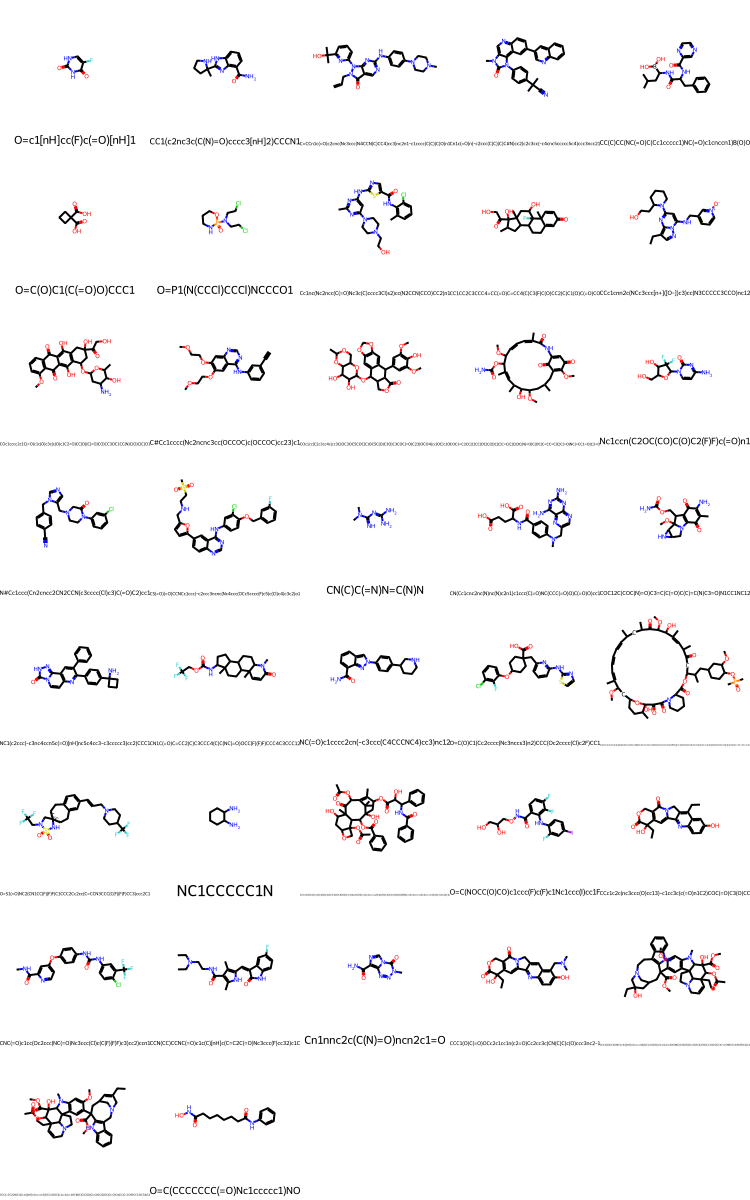

In [9]:
ver_moleculas=df
PandasTools.AddMoleculeColumnToFrame(ver_moleculas,'Droga')
[str(x) for x in  ver_moleculas.columns]
ver_moleculas = ver_moleculas[~ver_moleculas['ROMol'].isnull()]
PandasTools.FrameToGridImage(df,column= 'ROMol', molsPerRow=5,subImgSize=(150,150),legendsCol='Droga')



In [10]:
columns_to_map = ['Droga', 'Descritores',"morgan"]
for column in columns_to_map:
    mapping_dict = dict(zip(df['Droga'], df[column]))
    dataset[column+'d1'] = dataset['Drug1'].map(mapping_dict)
    dataset[column+'d2'] = dataset['Drug2'].map(mapping_dict)

# print(dataset)

In [11]:
a1=dataset["Descritoresd1"].apply(pd.Series)
a1.columns=[f"drug1 {x[0]}" for x in Descriptors._descList]
dataset=pd.concat([dataset,a1], axis=1)
dataset=dataset.drop("Descritoresd1", axis=1)
# dataset

In [12]:
b1=dataset["morgand1"].apply(pd.Series)
b1.columns=[f"morgan drug1 {i}" for i in range(b1.shape[1])]
dataset=pd.concat([dataset,b1], axis=1)
dataset=dataset.drop("morgand1", axis=1)

In [13]:
a2=dataset["Descritoresd2"].apply(pd.Series)
a2.columns=[f"drug2 {x[0]}" for x in Descriptors._descList]
dataset=pd.concat([dataset,a2], axis=1)
dataset=dataset.drop("Descritoresd2", axis=1)

In [14]:
b2=dataset["morgand2"].apply(pd.Series)
b2.columns=[f"morgan drug2 {i}" for i in range(b2.shape[1])]
dataset=pd.concat([dataset,b2], axis=1)
dataset=dataset.drop("morgand2", axis=1)


In [15]:
dataset

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2,Drogad1,Drogad2,drug1 MaxEStateIndex,...,morgan drug2 1014,morgan drug2 1015,morgan drug2 1016,morgan drug2 1017,morgan drug2 1018,morgan drug2 1019,morgan drug2 1020,morgan drug2 1021,morgan drug2 1022,morgan drug2 1023
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Neste momento temos o dataset original + drug 1 e 2 stander + parametro + descritores + morgan.

Com referência que os descritores já foram normalizados para media 0 e desvio padrão 1, as morgan fingerprint mantemos com valor binario, e as cell line ja tem media 0 e desvio padrao 1.

Decidimos dar drop a colunas cujos valores nao eram númericos, sabendo também que vamos verificar o valor NaN nas mesmas(pq isso seria errado).

In [16]:
linhas_com_nan = dataset[dataset.isnull().any(axis=1)]
linhas_com_nan_index = linhas_com_nan.index.intersection(dataset.index)

In [17]:
dataset_sem_nan = dataset.drop(linhas_com_nan_index)
dataset=dataset_sem_nan
dataset

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cell_Line,Drug1,Drug2,Drogad1,Drogad2,drug1 MaxEStateIndex,...,morgan drug2 1014,morgan drug2 1015,morgan drug2 1016,morgan drug2 1017,morgan drug2 1018,morgan drug2 1019,morgan drug2 1020,morgan drug2 1021,morgan drug2 1022,morgan drug2 1023
0,5-FU,ABT-888,A2058,7.693530,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5-FU,ABT-888,A2780,7.778053,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5-FU,ABT-888,A375,-1.198505,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5-FU,ABT-888,A427,2.595684,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5-FU,ABT-888,CAOV3,-5.139971,"[5.291146039856301, 5.040386719464342, 5.29114...",O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,O=c1[nH]cc(F)c(=O)[nH]1,CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,0.218360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,ZOLINZA,TOPOTECAN,UACC62,10.223066,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23048,ZOLINZA,TOPOTECAN,UWB1289BRCA1,20.551627,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23049,ZOLINZA,TOPOTECAN,UWB1289,12.190316,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23050,ZOLINZA,TOPOTECAN,VCAP,23.438547,"[-0.18899497244411118, -0.19839747536407973, -...",O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,O=C(CCCCCCC(=O)Nc1ccccc1)NO,CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O...,0.016257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Transformar o dataset para poder ser explorado, uma vez que iniciamente a coluna cell_line era uma lista com vários valores e, como posteriormente, iremos utilizar machine learning seria mais apropriado separar esses valores em features (que demos o nome de parametros).

Nota: os parametros são caracteristicas geneticas/expressão genetica das linhas celulares

In [18]:
#transfomar cada index da lista num parametro , parametros estes que seriam as features, num total de 8785 parametros
a=dataset["Cell_Line"].apply(pd.Series)
a.columns=[f"Parametro {i}" for i in range(a.shape[1])]
dataset=pd.concat([dataset,a], axis=1)
dataset=dataset.drop("Cell_Line", axis=1)

In [19]:
tipos_de_dados = dataset.dtypes

# Identificando colunas não numéricas
colunas_nao_numericas = tipos_de_dados[tipos_de_dados != 'float64'][tipos_de_dados != 'int64'].index
dataset = dataset.drop(columns=colunas_nao_numericas)


O dataset apresentado tem apenas as colunas com valores numericos e o proximo passo será filtragem do mesmo.

In [20]:
dataset #sem nan

,Y,drug1 MaxEStateIndex,drug1 MinEStateIndex,drug1 MaxAbsEStateIndex,drug1 MinAbsEStateIndex,drug1 qed,drug1 MolWt,drug1 HeavyAtomMolWt,drug1 ExactMolWt,drug1 NumValenceElectrons,...,Parametro 8775,Parametro 8776,Parametro 8777,Parametro 8778,Parametro 8779,Parametro 8780,Parametro 8781,Parametro 8782,Parametro 8783,Parametro 8784
0,7.693530,0.218360,-0.258188,0.218360,-0.195502,-0.203739,4.552044,4.441072,4.549836,1.540015,...,0.933708,0.433194,-0.705877,-0.797751,0.494978,-0.239587,1.279730,0.691891,-0.982503,-0.364565
1,7.778053,0.218360,-0.258188,0.218360,-0.195502,-0.203739,4.552044,4.441072,4.549836,1.540015,...,0.453011,0.868781,-0.548668,1.191511,0.947887,0.393898,1.241226,1.139293,-1.070203,-0.425415
2,-1.198505,0.218360,-0.258188,0.218360,-0.195502,-0.203739,4.552044,4.441072,4.549836,1.540015,...,-0.367088,-0.495932,-0.639091,-0.346006,-0.034777,-1.268040,-0.277364,-0.423137,-1.065120,-1.002490
3,2.595684,0.218360,-0.258188,0.218360,-0.195502,-0.203739,4.552044,4.441072,4.549836,1.540015,...,0.852838,-0.152449,-0.653551,0.369509,-0.358118,1.586969,1.275677,0.621267,-0.365272,-0.818869
4,-5.139971,0.218360,-0.258188,0.218360,-0.195502,-0.203739,4.552044,4.441072,4.549836,1.540015,...,-1.854093,-2.383995,0.068724,-0.583244,-2.238896,-1.288220,-1.650908,-1.705543,-0.714340,0.635244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,10.223066,0.016257,-0.264256,0.016257,-0.255508,-0.246824,5.948467,5.475267,5.944298,2.185288,...,0.989373,0.598182,-0.708544,-0.494359,-0.540534,-0.977627,-0.762502,0.882945,-1.073682,0.481022
23048,20.551627,0.016257,-0.264256,0.016257,-0.255508,-0.246824,5.948467,5.475267,5.944298,2.185288,...,0.159920,0.157617,2.134676,2.314793,0.981662,-0.019900,0.278455,-0.374227,-0.073559,-0.217856
23049,12.190316,0.016257,-0.264256,0.016257,-0.255508,-0.246824,5.948467,5.475267,5.944298,2.185288,...,0.159920,0.157617,2.134676,2.314793,0.981662,-0.019900,0.278455,-0.374227,-0.073559,-0.217856
23050,23.438547,0.016257,-0.264256,0.016257,-0.255508,-0.246824,5.948467,5.475267,5.944298,2.185288,...,0.345755,0.172750,-0.672222,-0.729491,0.774517,0.535449,0.406174,-0.436593,1.207464,-1.522136


### Feature Selection

Através do variance threshold (superior a 0.15), iremos filtrar as nossas features. Se, por exemplo, uma determinada feature tiver repetido o seu valor ao longo do dataset a mesma vai ser irrelevante logo podemos retirar.
PS: não houve razão cientifica para escolher 0.15

In [21]:
selector = VarianceThreshold(threshold=0.15)
selected_dataset = selector.fit_transform(dataset)
selected_columns = dataset.columns[selector.get_support()]
dataset_filtrado = pd.DataFrame(dataset, columns=selected_columns)
print("Shape do dataset após aplicar o Variance Threshold:", selected_dataset.shape)
print("Colunas selecionadas:", selected_columns)


Shape do dataset após aplicar o Variance Threshold: (19866, 8775)
Colunas selecionadas: Index(['Y', 'drug1 MolWt', 'drug1 HeavyAtomMolWt', 'drug1 ExactMolWt',
       'drug1 BertzCT', 'drug1 TPSA', 'morgan drug1 15', 'morgan drug1 33',
       'morgan drug1 36', 'morgan drug1 64',
       ...
       'Parametro 8775', 'Parametro 8776', 'Parametro 8777', 'Parametro 8778',
       'Parametro 8779', 'Parametro 8780', 'Parametro 8781', 'Parametro 8782',
       'Parametro 8783', 'Parametro 8784'],
      dtype='object', length=8775)


In [22]:
dataset_filtrado

,Y,drug1 MolWt,drug1 HeavyAtomMolWt,drug1 ExactMolWt,drug1 BertzCT,drug1 TPSA,morgan drug1 15,morgan drug1 33,morgan drug1 36,morgan drug1 64,...,Parametro 8775,Parametro 8776,Parametro 8777,Parametro 8778,Parametro 8779,Parametro 8780,Parametro 8781,Parametro 8782,Parametro 8783,Parametro 8784
0,7.693530,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.933708,0.433194,-0.705877,-0.797751,0.494978,-0.239587,1.279730,0.691891,-0.982503,-0.364565
1,7.778053,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.453011,0.868781,-0.548668,1.191511,0.947887,0.393898,1.241226,1.139293,-1.070203,-0.425415
2,-1.198505,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,-0.367088,-0.495932,-0.639091,-0.346006,-0.034777,-1.268040,-0.277364,-0.423137,-1.065120,-1.002490
3,2.595684,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.852838,-0.152449,-0.653551,0.369509,-0.358118,1.586969,1.275677,0.621267,-0.365272,-0.818869
4,-5.139971,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,-1.854093,-2.383995,0.068724,-0.583244,-2.238896,-1.288220,-1.650908,-1.705543,-0.714340,0.635244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,10.223066,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.989373,0.598182,-0.708544,-0.494359,-0.540534,-0.977627,-0.762502,0.882945,-1.073682,0.481022
23048,20.551627,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.159920,0.157617,2.134676,2.314793,0.981662,-0.019900,0.278455,-0.374227,-0.073559,-0.217856
23049,12.190316,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.159920,0.157617,2.134676,2.314793,0.981662,-0.019900,0.278455,-0.374227,-0.073559,-0.217856
23050,23.438547,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.345755,0.172750,-0.672222,-0.729491,0.774517,0.535449,0.406174,-0.436593,1.207464,-1.522136


## Análise da vaiável independente

Sabemos que:

Y < -10 a interação entre as drogas é antagónica  ( A+B tem menos efeito do que A ou B isoladas)

-10 > Y > 10 interação likety aditiva (A+B efeito da droga A + afeito da droga B)

Y > 10 interação synergistic  (mais efeitos da droga A e B do que de forma individual) [1,2]

Função para separar os Y no range que se encontram com o objetivo de fazer uma pieplot para mostrar visualmente a % de cada tipo de interação

(Informação referenciada na bibliografia, no final deste ficheiro.)


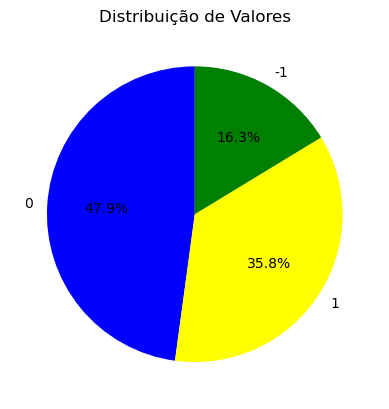

In [23]:
# Criar uma nova coluna chamada 'nova_coluna' com base nas condições
dataset_filtrado['nova_coluna'] = np.where(dataset_filtrado['Y'] <= -10, -1,
                                 np.where((dataset_filtrado['Y'] > -10) & (dataset['Y'] < 10), 0, 1))


# Contar a ocorrência de cada valor na coluna 'nova_coluna'
contagem_valores = dataset_filtrado['nova_coluna'].value_counts()

plt.pie(contagem_valores, labels=contagem_valores.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'yellow', 'green'])
plt.title('Distribuição de Valores')
plt.show() 

Neste gráfico é possivel verificar que a maior parte dos valores de Y se encontra entre -10 e 10. Todavia nós tinhamos como objetivo descobrir se há outliers, com o intuito de os eliminar.

Para isso realizamos o calculo dos outliers como demonstrado abaixo .

In [24]:
Q1 = dataset_filtrado['Y'].quantile(0.25)
Q3 = dataset_filtrado['Y'].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers
outliers = dataset_filtrado[(dataset_filtrado['Y'] < Q1 - 1.5 * IQR) | (dataset_filtrado['Y'] > Q3 + 1.5 * IQR)]
outliers 

,Y,drug1 MolWt,drug1 HeavyAtomMolWt,drug1 ExactMolWt,drug1 BertzCT,drug1 TPSA,morgan drug1 15,morgan drug1 33,morgan drug1 36,morgan drug1 64,...,Parametro 8776,Parametro 8777,Parametro 8778,Parametro 8779,Parametro 8780,Parametro 8781,Parametro 8782,Parametro 8783,Parametro 8784,nova_coluna
28,-36.459230,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,-0.099338,-0.609738,1.153684,0.142664,0.169037,-1.159675,1.316891,1.047211,0.008530,-1
75,70.158169,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.157617,2.134676,2.314793,0.981662,-0.019900,0.278455,-0.374227,-0.073559,-0.217856,1
91,55.291299,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.982001,-0.673826,-0.734159,-0.133759,-0.275352,-0.693002,1.226429,1.300139,1.713150,1
106,-73.138402,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,-0.099338,-0.609738,1.153684,0.142664,0.169037,-1.159675,1.316891,1.047211,0.008530,-1
111,106.007192,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.411236,-0.602868,0.400484,0.330804,-0.885652,-1.194136,1.302562,1.361955,1.422579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22821,-54.421852,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,-0.152449,-0.653551,0.369509,-0.358118,1.586969,1.275677,0.621267,-0.365272,-0.818869,-1
22831,71.114946,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.982001,-0.673826,-0.734159,-0.133759,-0.275352,-0.693002,1.226429,1.300139,1.713150,1
22873,57.501999,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.432964,-0.635646,-0.769913,1.320790,1.187980,0.104732,-0.833383,-1.035904,0.446369,1
22987,50.720943,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.982001,-0.673826,-0.734159,-0.133759,-0.275352,-0.693002,1.226429,1.300139,1.713150,1


Verificamos que tendo em conta as conta realizadas teriamos cerca de 1292 outliers. Face a isso decidimos realizar o gráfico abaixo para ter uma noção mais visual da distribuição dos valores de Y e respetiva frequencia.

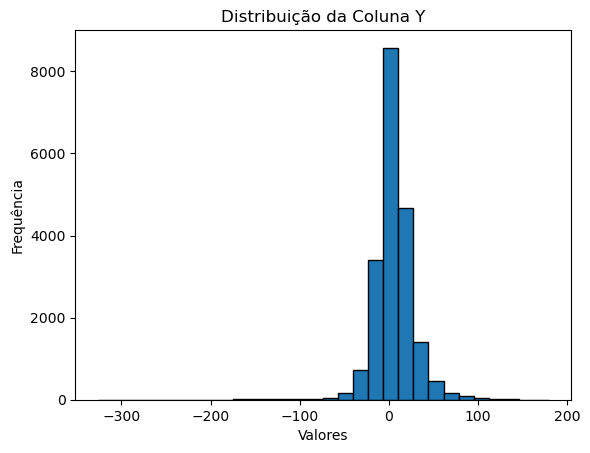

In [25]:
coluna_Y = 'Y'

# Crie um gráfico de distribuição
plt.hist(dataset[coluna_Y], bins=30, edgecolor='black')
plt.title('Distribuição da Coluna Y')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show() 

Aqui realmente podemos verificar que a maior parte dos valores encontra-se entre -50 e 50 e, como tal decidimos considerar que os valores obtidos como outliers deveriam ser eliminados permitindo filtrar o dataset ao nivel das linhas.

Para ter um noção em percentagem conseguimos verificar que essa remoção corresponde a 4 % do dosso dataset.

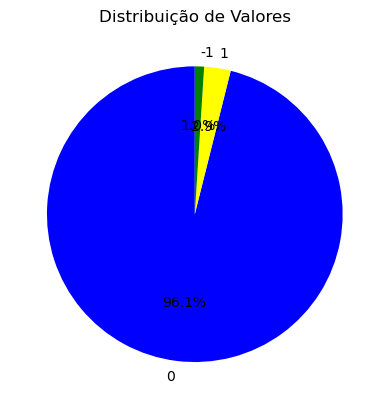

In [26]:
# Criar uma nova coluna chamada 'nova_coluna' com base nas condições
dataset_filtrado['nova_coluna'] = np.where(dataset_filtrado['Y'] <= -50, -1,
                                 np.where((dataset_filtrado['Y'] > -50) & (dataset_filtrado['Y'] < 50), 0, 1))

# Contar a ocorrência de cada valor na coluna 'nova_coluna'
contagem_valores = dataset_filtrado['nova_coluna'].value_counts()

# Criar um gráfico de pizza
plt.pie(contagem_valores, labels=contagem_valores.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'yellow', 'green'])
plt.title('Distribuição de Valores')
plt.show()


In [27]:
dataset_sem_outliers = dataset_filtrado.drop(outliers.index)
dataset_sem_outliers

,Y,drug1 MolWt,drug1 HeavyAtomMolWt,drug1 ExactMolWt,drug1 BertzCT,drug1 TPSA,morgan drug1 15,morgan drug1 33,morgan drug1 36,morgan drug1 64,...,Parametro 8776,Parametro 8777,Parametro 8778,Parametro 8779,Parametro 8780,Parametro 8781,Parametro 8782,Parametro 8783,Parametro 8784,nova_coluna
0,7.693530,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.433194,-0.705877,-0.797751,0.494978,-0.239587,1.279730,0.691891,-0.982503,-0.364565,0
1,7.778053,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,0.868781,-0.548668,1.191511,0.947887,0.393898,1.241226,1.139293,-1.070203,-0.425415,0
2,-1.198505,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,-0.495932,-0.639091,-0.346006,-0.034777,-1.268040,-0.277364,-0.423137,-1.065120,-1.002490,0
3,2.595684,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,-0.152449,-0.653551,0.369509,-0.358118,1.586969,1.275677,0.621267,-0.365272,-0.818869,0
4,-5.139971,4.552044,4.441072,4.549836,11.258666,2.190289,0.0,0.0,0.0,0.0,...,-2.383995,0.068724,-0.583244,-2.238896,-1.288220,-1.650908,-1.705543,-0.714340,0.635244,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23047,10.223066,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.598182,-0.708544,-0.494359,-0.540534,-0.977627,-0.762502,0.882945,-1.073682,0.481022,0
23048,20.551627,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.157617,2.134676,2.314793,0.981662,-0.019900,0.278455,-0.374227,-0.073559,-0.217856,0
23049,12.190316,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.157617,2.134676,2.314793,0.981662,-0.019900,0.278455,-0.374227,-0.073559,-0.217856,0
23050,23.438547,5.948467,5.475267,5.944298,8.967280,1.585104,0.0,0.0,0.0,1.0,...,0.172750,-0.672222,-0.729491,0.774517,0.535449,0.406174,-0.436593,1.207464,-1.522136,0


In [28]:
ultima_coluna = dataset_filtrado.columns[-1]

# Remover a última coluna
dataset_final = dataset_filtrado.drop(columns=[ultima_coluna])

Converter o dataset final para um ficheiro csv

In [29]:
dataset_final.to_csv('dataset.csv', index=False)

### Referências Bibliográficas

[1] https://synergyfinder.fimm.fi/synergy/synfin_docs/#welcome

[2] https://bmcresnotes.biomedcentral.com/articles/10.1186/s13104-021-05445-7